In [572]:
import pandas as pd
import numpy as np
import ast
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# train_full_class_df = pd.read_csv("/content/drive/MyDrive/train_new.csv")
train_df = pd.read_csv("/content/drive/MyDrive/test_new.csv")
# real_test_df = pd.read_excel("/content/drive/MyDrive/behaviour_simulation_test_company.xlsx")
val_df = pd.read_csv("/content/drive/MyDrive/val_pipeline.csv")

#val_df = pd.read_csv("/content/drive/MyDrive/behaviour_simulation_test_company_new.csv")

In [573]:
train_df = train_df[train_df['likes'] > 9000]
val_df = val_df[val_df['likes'] > 9000]

In [574]:
train_text = []
val_text = []

for index, row in train_df.iterrows():
  stri = f"""
  username: {row['username']},
  company: {row['inferred company']},
  image url status: {row['image_url_status']},
  video url status: {row['video_thumbnail_status']},
  gif url status: {row['gif_thumbnail_status']}
  """
  train_text.append(stri)

for index, row in val_df.iterrows():
  stri = f"""
  username: {row['username']},
  company: {row['inferred company']},
  image url status: {row['image_url_status']},
  video url status: {row['video_thumbnail_status']},
  gif url status: {row['gif_thumbnail_status']}
  """
  val_text.append(stri)

In [575]:
train_df = train_df.drop(columns=['image_url', 'video_thumbnail_url', 'video_url',
                    'gif_thumbnail_url', 'gif_url', 'is_url_active', 'date', 'media', 'Unnamed: 0', 'text_status', 'image_url_status', 'video_url_status', 'video_thumbnail_status','gif_thumbnail_status', 'gif_url_status', 'inferred company'])

train_df['video_bitrate'] = train_df['video_bitrate'].replace("Does not exist", 0)
train_df['video_bitrate'] = train_df['video_bitrate'].replace("0", 0)
train_df['video_duration'] = train_df['video_duration'].replace("Does not exist", 0)
train_df['video_duration'] = train_df['video_duration'].replace("0", 0)
train_df['video_views'] = train_df['video_views'].replace("Does not exist", 0)
train_df['video_views'] = train_df['video_views'].replace("0", 0)

train_df['gif_bitrate'] = train_df['gif_bitrate'].replace("Does not exist", 0)
train_df['gif_bitrate'] = train_df['gif_bitrate'].replace("0", 0)

train_df['video_bitrate'] = train_df['video_bitrate'].astype(float)
train_df['video_duration'] = train_df['video_duration'].astype(float)
train_df['video_views'] = train_df['video_views'].astype(float)
train_df['gif_bitrate'] = train_df['gif_bitrate'].astype(float)

def convert_to_tuple(string):
    return ast.literal_eval(string)

train_df['image_size'] = train_df['image_size'].fillna('(0, 0)')
train_df['image_size'] = train_df['image_size'].apply(convert_to_tuple)

train_df[['image_heigth', 'image_width']] = pd.DataFrame(train_df['image_size'].tolist(), columns=['image_height', 'image_heigth'])

train_df.drop('image_size', axis=1, inplace=True)
train_df['languages'] = train_df['languages'].str.strip("[]")
train_df['languages'] = train_df['languages'].str.strip("'")

for language in train_df['languages'].unique():
  if language != 'ENGLISH' and language != 'Unknown':
    train_df['languages'] = train_df['languages'].replace(language, "Another Language")

train_df = train_df.drop(columns=['username', 'content'])

likes_list = train_df['likes']

train_df = pd.get_dummies(train_df)
len(train_df.columns)

41

In [576]:
train_df.columns

Index(['video_bitrate', 'video_duration', 'video_views', 'gif_bitrate', 'year',
       'day_of_year', 'likes', 'emoji_count', 'hastag_count',
       'uppercase_count', 'at_count', 'sentiment_score', 'subjectivity_score',
       'word_count', 'image_heigth', 'image_width',
       'languages_Another Language', 'languages_ENGLISH', 'languages_Unknown',
       'month_April', 'month_August', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'media_type_gif', 'media_type_image',
       'media_type_video'],
      dtype='object')

In [577]:
val_df = val_df.drop(columns=['image_url', 'video_thumbnail_url', 'video_url',
                    'gif_thumbnail_url', 'gif_url', 'is_url_active', 'date', 'media', 'Unnamed: 0', 'text_status', 'image_url_status', 'video_url_status', 'video_thumbnail_status','gif_thumbnail_status', 'gif_url_status', 'username', 'inferred company'])

val_df['video_bitrate'] = val_df['video_bitrate'].replace("Does not exist", 0)
val_df['video_bitrate'] = val_df['video_bitrate'].replace("0", 0)
val_df['video_duration'] = val_df['video_duration'].replace("Does not exist", 0)
val_df['video_duration'] = val_df['video_duration'].replace("0", 0)
val_df['video_views'] = val_df['video_views'].replace("Does not exist", 0)
val_df['video_views'] = val_df['video_views'].replace("0", 0)

val_df['gif_bitrate'] = val_df['gif_bitrate'].replace("Does not exist", 0)
val_df['gif_bitrate'] = val_df['gif_bitrate'].replace("0    0\nName: gif_bitrate, dtype: object", 0)

val_df['video_bitrate'] = val_df['video_bitrate'].astype(float)
val_df['video_duration'] = val_df['video_duration'].astype(float)
val_df['video_views'] = val_df['video_views'].astype(float)
val_df['gif_bitrate'] = val_df['gif_bitrate'].astype(float)

def convert_to_tuple(string):
    return ast.literal_eval(string)

val_df['image_size'] = val_df['image_size'].fillna('(0, 0)')
val_df['image_size'] = val_df['image_size'].apply(convert_to_tuple)

val_df[['image_heigth', 'image_width']] = pd.DataFrame(val_df['image_size'].tolist(), columns=['image_height', 'image_heigth'])

val_df.drop('image_size', axis=1, inplace=True)
val_df['languages'] = val_df['languages'].str.strip("[]")
val_df['languages'] = val_df['languages'].str.strip("'")

for language in val_df['languages'].unique():
  if language != 'ENGLISH' and language != 'Unknown':
    val_df['languages'] = val_df['languages'].replace(language, "Another Language")

val_df = val_df.drop(columns=['content'])
val_df = pd.get_dummies(val_df)

if 'languages_Another Language' not in val_df.columns:
  val_df['languages_Another Language'] = 0

val_column_order = ['video_bitrate', 'video_duration', 'video_views', 'gif_bitrate', 'year',
       'day_of_year', 'likes', 'emoji_count', 'hastag_count',
       'uppercase_count', 'at_count', 'sentiment_score', 'subjectivity_score',
       'word_count', 'image_heigth', 'image_width',
       'languages_Another Language', 'languages_ENGLISH', 'languages_Unknown',
       'month_April', 'month_August', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'media_type_gif', 'media_type_image',
       'media_type_video']

val_df = val_df.reindex(columns=val_column_order)

len(val_df.columns)

41

In [578]:
loaded_model = xgb.Booster()
loaded_model.load_model('/content/drive/MyDrive/xg_boost_outlier_score_model.bin')

In [579]:
train_df_likes = train_df['likes'].values
train_df = train_df.drop(columns=['likes'])
val_df_likes = val_df['likes'].values
val_df = val_df.drop(columns=['likes'])

In [580]:
max(train_df_likes), max(val_df_likes)

(389438, 288909)

In [581]:
X = train_df
y = train_df_likes
dtrain = xgb.DMatrix(data=X, label=y)
predictions_train = loaded_model.predict(dtrain)

X = val_df
# y = val_df_likes
dtest = xgb.DMatrix(data=X)
predictions_test = loaded_model.predict(dtest)

In [582]:
train_df['outlier_score'] = predictions_train
val_df['outlier_score'] = predictions_test

In [583]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

X_train, y_train = train_df, train_df_likes
X_test, y_test = val_df, val_df_likes

quantile_transformer = QuantileTransformer(output_distribution='normal')
y_transformed_train = quantile_transformer.fit_transform(y_train.reshape(-1, 1)).flatten()
y_transformed_test = quantile_transformer.transform(y_test.reshape(-1, 1)).flatten()

vectorizer = TfidfVectorizer()
X_train_text = vectorizer.fit_transform(train_text)
X_test_text = vectorizer.transform(val_text)

params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'objective': 'reg:squarederror'
}

dtrain = xgb.DMatrix(X_train, label=y_transformed_train)
dtest = xgb.DMatrix(X_test)

num_round = 100
model = xgb.train(params, dtrain, num_round)

train_predictions = model.predict(dtrain)
text_regressor = LinearRegression()
text_regressor.fit(X_train_text, y_transformed_train)
train_text_predictions = text_regressor.predict(X_train_text)
train_combined_features = np.column_stack((train_text_predictions, train_predictions))
meta_model = LinearRegression()
meta_model.fit(train_combined_features, y_transformed_train)

test_predictions = model.predict(dtest)
test_text_predictions = text_regressor.predict(X_test_text)
test_combined_features = np.column_stack((test_text_predictions, test_predictions))
predictions = meta_model.predict(test_combined_features)

y_pred_inverse = quantile_transformer.inverse_transform(predictions.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_pred_inverse, y_test)
print(f"Root Mean Squared Error (MSE): {np.sqrt(mse)}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (766). n_quantiles is set to n_samples.
  warnings.warn(


Root Mean Squared Error (MSE): 31384.428118316726


In [584]:
# import math
# val_df['likes'] = [round(num) for num in y_pred_inverse]
# max(y_pred_inverse)
# val_df.head()
# real_test_df['likes'] = val_df['likes']
# real_test_df.to_csv('/content/drive/MyDrive/company.csv')

In [585]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_inverse)

-0.07215467773455586

In [586]:
var1 = y_test
var2 = y_pred_inverse
sorted_indices = np.argsort(var1)
sorted_var1 = var1[sorted_indices]
sorted_var2 = var2[sorted_indices]

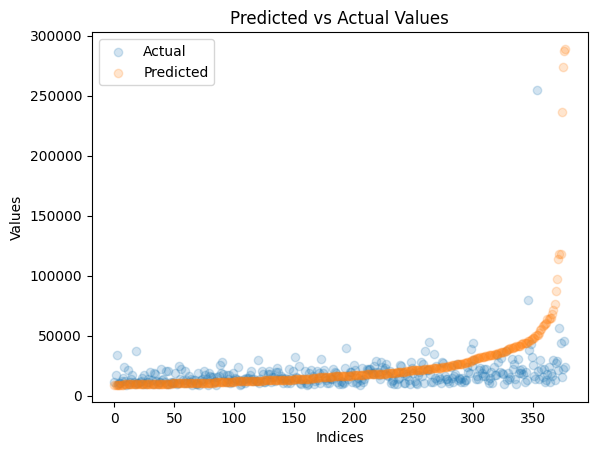

In [587]:
indices = np.arange(len(sorted_var1))

# Plot
plt.scatter(indices, sorted_var2, label='Actual', alpha = 0.2)
plt.scatter(indices, sorted_var1, label='Predicted', alpha = 0.2)

# Labels and Title
plt.xlabel('Indices')
plt.ylabel('Values')
plt.title('Predicted vs Actual Values')

# Legend
plt.legend()

# Show plot
plt.show()

In [588]:
from joblib import dump, load

dump(model, "xgboost_9000_to_inf.joblib")
loaded_model = load("xgboost_9000_to_inf.joblib")
loaded_test_predictions = loaded_model.predict(dtest)

dump(text_regressor, "text_regressor_9000_to_inf.joblib")
loaded_model = load("text_regressor_9000_to_inf.joblib")
loaded_test_text_predictions = loaded_model.predict(X_test_text)

dump(meta_model, "meta_model_9000_to_inf.joblib")
loaded_model = load("meta_model_9000_to_inf.joblib")
loaded_test_combined_predictions = loaded_model.predict(test_combined_features)

test_predictions == loaded_test_predictions, predictions == loaded_test_combined_predictions, test_text_predictions == loaded_test_text_predictions

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      